In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype("float32") / 225.0
X_test = X_test.astype("float32") / 225.0

x_train = tf.expand_dims(X_train, axis=-1)
x_test = tf.expand_dims(X_test, axis=-1)

print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [3]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ]
)

print(discriminator.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        544       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          32832     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dropout (Dropout)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [4]:
latent_dim = 64
generator = keras.Sequential(
    [
        layers.Input(shape=(latent_dim,)),
        layers.Dense(8*8*64),
        layers.Reshape((8, 8, 64)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(1, kernel_size=5, activation="sigmoid"),
    ]
)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              266240    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      131200    
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 128)      

In [5]:
class GAN(keras.Model):

  def __init__(self, discriminator, generator, latent_dim):

    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
 
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  @property
  def metrics(self):
  
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    
    # Sample random points in the latent space
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Decode them to fake images
    generated_images = self.generator(random_latent_vectors)

    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0 )
   # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    # Train the discriminator
    with tf.GradientTape() as tape:
    
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Assemble labels that say "all real images"
    misleading_labels = tf.ones((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
   
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    # Update metrics
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {"d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()}

In [6]:
epochs = 5

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(x_train, epochs=epochs)

Epoch 1/5
1875/1875 [==============================] - 35s 13ms/step - d_loss: 0.5672 - g_loss: 0.8247
Epoch 2/5
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.3680 - g_loss: 1.2747
Epoch 3/5
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.3024 - g_loss: 1.5234
Epoch 4/5
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.2729 - g_loss: 1.6750
Epoch 5/5
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.2320 - g_loss: 1.8267


In [7]:
random_noise = tf.random.normal(shape=(4, 64))

In [10]:
trained_gen = gan.generator

In [11]:
out = trained_gen.predict(random_noise)

1/1 [==============================] - 0s 157ms/step


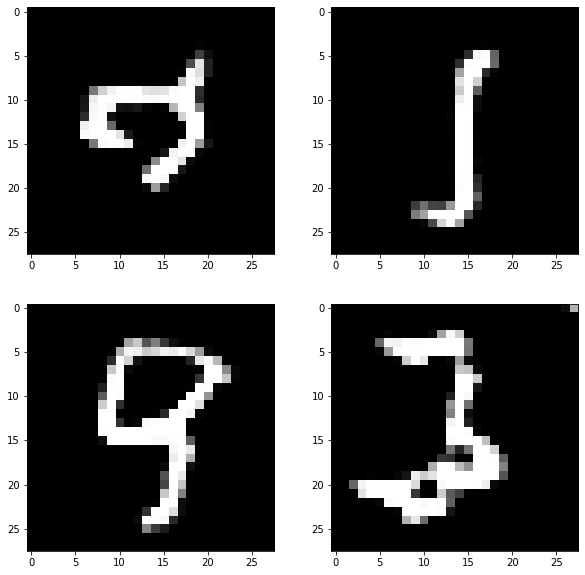

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2,2,i+1)   
    plt.imshow(tf.reshape(out[i,:,:,:], (28,28)), cmap='gray')

plt.show()